## Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io 
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Dataset Processing 

### Read in the original dataset 

In [2]:
train_dl_origin = torch.load('Dataset/train_dl.pt')
valid_dl_origin = torch.load('Dataset/valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,0:2]

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,0:2]

In [3]:
print(train_label)

tensor([[-37.2707, -21.4267],
        [-38.7407, -16.3757],
        [-25.9407, -16.6947],
        ...,
        [-32.1957, -22.0517],
        [-16.1297, -14.0287],
        [-37.0697, -16.6887]])


### CSI Processing: Take Modulus of complex matrices

In [4]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

In [5]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)
print(train_label.shape)
print(valid_label.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])
torch.Size([15000, 2])
torch.Size([5000, 2])


###  CSI Processing: Normalize to [0,1]

In [6]:
# Min-Max Scaling
min_value = torch.min(train_CSI_modulus)
max_value = torch.max(train_CSI_modulus)

normalized_train_CSI_modulus = (train_CSI_modulus - min_value) / (max_value - min_value)
normalized_valid_CSI_modulus = (valid_CSI_modulus - min_value) / (max_value - min_value)

In [7]:
# Convert 4d to 2d
train_data_2d = normalized_train_CSI_modulus.view(normalized_train_CSI_modulus.size(0), -1)  # Reshape to (15000, 4 * 1632)
valid_data_2d = normalized_valid_CSI_modulus.view(normalized_valid_CSI_modulus.size(0), -1)  # Reshape to (15000, 4 * 1632)

In [8]:
train_data_2d.shape
valid_data_2d.shape

torch.Size([5000, 6528])

#   ML w/ Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
# Create the model
model = LinearRegression()
# Fit the model
model.fit(train_data_2d, train_label)
# Score the model
print(model.score(train_data_2d, train_label))
print(model.score(valid_data_2d, valid_label))


0.9018167298339954
0.6891206395129608


In [9]:
from sklearn.metrics import mean_squared_error
train_predictions = model.predict(train_data_2d)
valid_predictions = model.predict(valid_data_2d)
train_mse = mean_squared_error(train_label, train_predictions)
valid_mse = mean_squared_error(valid_label, valid_predictions)

### Lets use L1 regularization now
- We expect this to perform poorly since all features are equally important

In [11]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=.1, normalize=False)
lasso_model.fit(train_data_2d, train_label)

C:\Users\Joey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Lasso(alpha=0.1, normalize=False)

In [12]:
train_score = lasso_model.score(train_data_2d, train_label)
valid_score = lasso_model.score(valid_data_2d, valid_label)

print("Training R-squared:", train_score)
print("Validation R-squared:", valid_score)

Training R-squared: 0.28614985912199603
Validation R-squared: 0.28412069940421636


In [13]:
train_predictions_l = lasso_model.predict(train_data_2d)
valid_predictions_l = lasso_model.predict(valid_data_2d)
train_mse_l = mean_squared_error(train_label, train_predictions_l)
valid_mse_l = mean_squared_error(valid_label, valid_predictions_l)


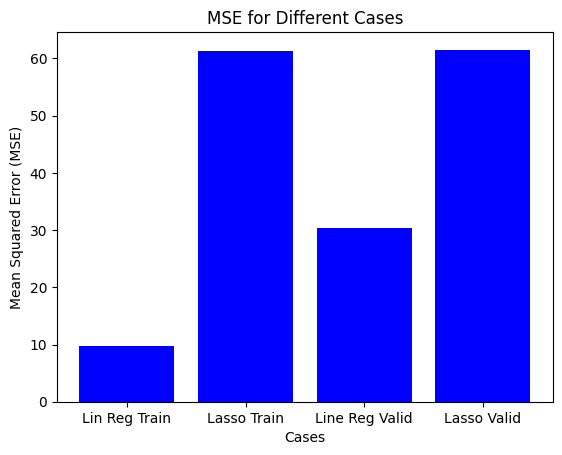

In [14]:
mse_values = [train_mse, train_mse_l, valid_mse, valid_mse_l]  
case_labels = ['Lin Reg Train', 'Lasso Train', 'Line Reg Valid', 'Lasso Valid']  

plt.bar(case_labels, mse_values, color='blue')
plt.xlabel('Cases')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Cases')

plt.show()

# MLP Approach

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(4 * 1632, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        
        self.layer2 = nn.Linear(2048, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        
        self.layer3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.layer4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        
        self.layer5 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(128)
        
        self.layer6 = nn.Linear(128, 32)
        self.bn6 = nn.BatchNorm1d(32)
        
        self.layer7 = nn.Linear(32, 16)
        self.bn7 = nn.BatchNorm1d(16)
        
        self.layer8 = nn.Linear(16, 8)
        self.bn8 = nn.BatchNorm1d(8)
        
        self.layer9 = nn.Linear(8, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.bn2(self.layer2(x)))
        x = F.relu(self.bn3(self.layer3(x)))
        x = F.relu(self.bn4(self.layer4(x)))
        x = F.relu(self.bn5(self.layer5(x)))
        x = F.relu(self.bn6(self.layer6(x)))
        x = F.relu(self.bn7(self.layer7(x)))
        x = F.relu(self.bn8(self.layer8(x)))
        x = self.layer9(x)
        return x

net = Net()



In [46]:
import torch.optim as optim
import copy
from sklearn.model_selection import KFold  
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR



num_folds = 2
kf = KFold(n_splits=num_folds)
best_model_states = []
best_losses = []
torch.autograd.set_detect_anomaly(True)

for train_index, valid_index in kf.split(train_data_2d):
    # Split the data into training and validation sets for each fold
    X_train_fold, X_valid_fold = train_data_2d[train_index], train_data_2d[valid_index]
    y_train_fold, y_valid_fold = train_label[train_index], train_label[valid_index]

    net = Net() 
     
    for m in net.modules():
        if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    optimizer = optim.SGD(net.parameters(), lr=0.08)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.7)
    criterion = nn.MSELoss()

    best_loss = float('inf')  
    best_model_state_dict = None

    num_epochs = 20

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = net(X_train_fold)
        loss = criterion(output, y_train_fold)

        loss.backward()
        optimizer.step()
        scheduler.step()
        print('Epoch %d/%d, Training Loss: %.4f' % (epoch+1, num_epochs, loss.item()))
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state_dict = copy.deepcopy(net.state_dict())

    best_model_states.append(best_model_state_dict)
    best_losses.append(best_loss)

best_fold = best_losses.index(min(best_losses))
best_model_state_dict = best_model_states[best_fold]
net = Net()  # Initialize a new model
net.load_state_dict(best_model_state_dict)


Epoch 1/20, Training Loss: 410.0854
Epoch 2/20, Training Loss: 299.5654
Epoch 3/20, Training Loss: 153.9264
Epoch 4/20, Training Loss: 91.4851
Epoch 5/20, Training Loss: 146.2516
Epoch 6/20, Training Loss: 90.7248
Epoch 7/20, Training Loss: 86.0117
Epoch 8/20, Training Loss: 59.4277
Epoch 9/20, Training Loss: 54.1473
Epoch 10/20, Training Loss: 52.4218
Epoch 11/20, Training Loss: 49.8629
Epoch 12/20, Training Loss: 48.4860
Epoch 13/20, Training Loss: 47.5422
Epoch 14/20, Training Loss: 46.6489
Epoch 15/20, Training Loss: 45.5009
Epoch 16/20, Training Loss: 44.6823
Epoch 17/20, Training Loss: 43.8028
Epoch 18/20, Training Loss: 43.1483
Epoch 19/20, Training Loss: 42.5822
Epoch 20/20, Training Loss: 41.8588
Epoch 1/20, Training Loss: 372.0541
Epoch 2/20, Training Loss: 209.4011
Epoch 3/20, Training Loss: 124.4867
Epoch 4/20, Training Loss: 301.6957
Epoch 5/20, Training Loss: 219.1861
Epoch 6/20, Training Loss: 89.3561
Epoch 7/20, Training Loss: 71.3848
Epoch 8/20, Training Loss: 68.5521


<All keys matched successfully>

In [47]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
net.eval()
with torch.no_grad():
    train_predictions = net(train_data_2d)
    test_predictions = net(valid_data_2d)
print("Training R-squared:", r2_score(train_label, train_predictions))
print("Validation R-squared:", r2_score(valid_label, test_predictions))
print("Training MSE:", mean_squared_error(train_label, train_predictions))
print("Validation MSE:", mean_squared_error(valid_label, test_predictions))
print("Training MAE:", mean_absolute_error(train_label, train_predictions))
print("Validation MAE:", mean_absolute_error(valid_label, test_predictions))


Training R-squared: 0.4375718950339412
Validation R-squared: 0.4262174959082957
Training MSE: 52.06987
Validation MSE: 53.257336
Training MAE: 5.7119946
Validation MAE: 5.766329


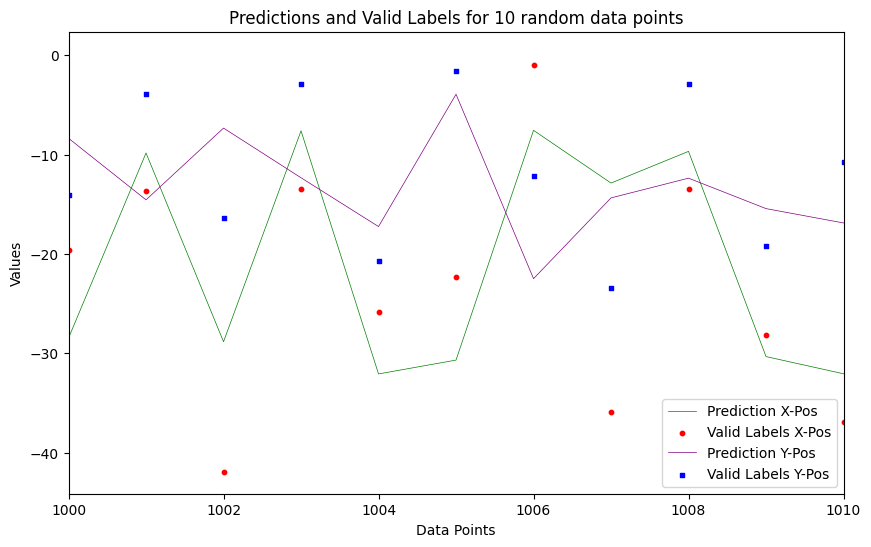

In [48]:
plt.figure(figsize=(10, 6))

# Plot prediction lines
plt.plot(test_predictions[:, 0], label='Prediction X-Pos', color='green', linewidth=.5)
plt.scatter(np.arange(len(valid_label)), valid_label[:, 0], label='Valid Labels X-Pos', color='red', marker='o', s=10)
plt.plot(test_predictions[:, 1], label='Prediction Y-Pos', color='purple', linewidth=.5)
plt.scatter(np.arange(len(valid_label)), valid_label[:, 1], label='Valid Labels Y-Pos', color='blue', marker='s', s=10)

# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()

# Add a title
plt.title('Predictions and Valid Labels for 10 random data points')
plt.xlim(1000, 1010)
# Show the plot
plt.show()